Yitzhak Cohen

This program attempts to get as many conclusions as possible , using only unsupervised methods.
It has 2 parts:
1. data analysis
2. Clustering and Dimension reduction methods.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import gc
from itertools import combinations
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.cluster import SpectralClustering
from sklearn import metrics

/home/lizard/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [7]:
# Read the Data
diabetic_data = pd.read_csv('dataset_diabetes/diabetic_data.csv')

In [3]:
# The icd9 codes description , just to understand the diagnoses.
diag_codes = pd.read_csv('icd9.csv',names=['code','diag_description'])
diag_codes_dict = dict(zip(diag_codes['code'].values,diag_codes['diag_description'].values))
def get_description(diag):
    if diag in diag_codes_dict.keys():
        ret = diag_codes_dict[diag]
    else:
        ret = diag
    return ret

In [6]:
# The description of the features : admission_source_id , discharge_disposition_id, admission_type_id
ids_mapping_dict = {}
key = ''
with open('dataset_diabetes/IDs_mapping.csv','r') as f:
    for line in  f.readlines():
        line =  line.strip()
        if line == ',':
            continue
        vals = line.split(',')
        if vals[1] == 'description':
            key = vals[0]
            ids_mapping_dict[key] = {}
            continue
        else:
            ids_mapping_dict[key][vals[0]]=  vals[1]

In [2]:
# Seperate the columns into numerical and nominal columns , they should be handled differently.
nominal_columns = [u'race', u'gender', u'age',
       u'admission_type_id', u'discharge_disposition_id',
       u'admission_source_id', u'payer_code',
       u'medical_specialty', u'diag_1', u'diag_2', u'diag_3',
       u'max_glu_serum', u'A1Cresult', u'change', u'diabetesMed', u'readmitted']

numeric_columns = [u'time_in_hospital',u'num_lab_procedures', u'num_procedures',
       u'num_medications', u'number_outpatient', u'number_emergency',
       u'number_inpatient','number_diagnoses']

medication_columns = [u'metformin',u'repaglinide', u'nateglinide', u'chlorpropamide', u'glimepiride',
       u'acetohexamide', u'glipizide', u'glyburide', u'tolbutamide',
       u'pioglitazone', u'rosiglitazone', u'acarbose', u'miglitol',
       u'troglitazone', u'tolazamide', u'examide', u'citoglipton', u'insulin',
       u'glyburide-metformin', u'glipizide-metformin',
       u'glimepiride-pioglitazone', u'metformin-rosiglitazone',
       u'metformin-pioglitazone']

cols_to_remove  = [u'encounter_id', u'patient_nbr',u'weight']

In [8]:
# Get the features  admission_source_id , discharge_disposition_id, admission_type_id description instead of integer code.
diabetic_data['admission_source_id'] = diabetic_data['admission_source_id'].apply(lambda x: ids_mapping_dict['admission_source_id'][str(x)])
diabetic_data['discharge_disposition_id'] = diabetic_data['discharge_disposition_id'].apply(lambda x: ids_mapping_dict['discharge_disposition_id'][str(x)])
diabetic_data['admission_type_id'] = diabetic_data['admission_type_id'].apply(lambda x: ids_mapping_dict['admission_type_id'][str(x)])

In [9]:
# Ge the diagnoses description , instead of icd9 code.
diabetic_data['diag_1'] = diabetic_data['diag_1'].apply(get_description)
diabetic_data['diag_2'] = diabetic_data['diag_2'].apply(get_description)
diabetic_data['diag_3'] = diabetic_data['diag_3'].apply(get_description)

# Features Connection

This is the data analysis part,  find which nominal features are connected , and which numerical features are correlated

In [9]:
# Since some patients have more than one encounter , only keep analyze each patient's first encounter.
diabetic_data['encounter_id'] = diabetic_data['encounter_id'].astype('int')
patient_first_encounter = diabetic_data[[u'encounter_id', u'patient_nbr']].groupby('patient_nbr').min()['encounter_id'].reset_index()
diabetic_data_first_encounter = diabetic_data.merge(patient_first_encounter,on=['patient_nbr','encounter_id'])

In [ ]:
diabetic_data_first_encounter[numeric_columns].corr().to_csv('corr.csv')

In [112]:
arr = []
threshold = 1.5
samples_thres = 100
for comb in combinations(nominal_columns,2):
    ct = pd.crosstab(diabetic_data_first_encounter[comb[0]],diabetic_data_first_encounter[comb[1]])
    norm_ct = ct.fillna(0).apply(lambda r: r/r.sum(), axis=1).apply(lambda r: r/r.sum(), axis=1)
    norm_ct = norm_ct[ct>samples_thres].fillna(0)
    distribution = diabetic_data_first_encounter[comb[1]].value_counts(normalize=True)
    for col in norm_ct.columns:
        norm_ct[col] =  norm_ct[col] / distribution[col]
    res = norm_ct[(norm_ct> threshold) | (norm_ct <  (1.0/threshold))].dropna(how='all',axis=1).dropna(how='all',axis=0)
    if res.shape[0] > 0:
        col1 = res.index.name
        col2 = res.columns.name
        for row in res.iterrows():
            for idx,val in enumerate(row[1],0):
                if val > 0:
                    arr.append([col1,row[0],col2,row[1].keys()[idx],val,ct.loc[row[0],row[1].keys()[idx]]])

res_df = pd.DataFrame(arr,columns = ['feature 1','value 1','feature 2','value 2','ratio','num samples'])
res_df.to_csv('res_first_encounter.csv',index=False)

[0-10)
[10-20)
[20-30)
[30-40)
[40-50)
[50-60)
[60-70)
[70-80)
[80-90)
[90-100)


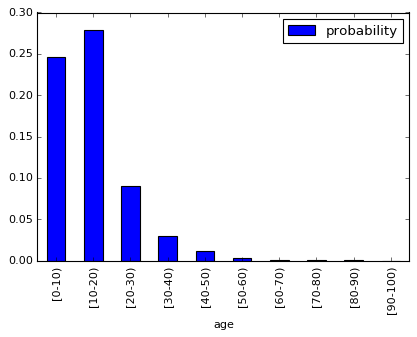

In [125]:
# Some interesting polts
arr = []
for age in diabetic_data_first_encounter['age'].unique():
    try:
        val = diabetic_data_first_encounter[diabetic_data_first_encounter['age']==age]\
    ['diag_1'].value_counts(normalize=True)['250.13']
    except:
        val = 0
    arr.append([age,val])
plt_df = pd.DataFrame(arr,columns=['age','probability'])
plt_df.set_index('age').plot(kind='bar')

# Clustering

This section attempts to create cluster using several techniques

### 1. K-Means

In [ ]:
# Features characterizing the patient demographic and medical condition prior to his hospialization
patient_features  = [u'race', u'gender', u'age',u'admission_type_id',u'admission_source_id',\
                     u'payer_code',u'number_outpatient', u'number_emergency',u'number_inpatient']


patient_df = diabetic_data_first_encounter[patient_features]

# Change age into numerical feature by taking each group average.
def get_age(age_group):
    return np.mean([int(x) for x in age_group.replace('[','').replace(')','').split('-')])

patient_df['age'] = patient_df['age'].apply(get_age)

# Normalize numerical colum , in order to keep then pretty much on the same scale as the one hot features.
cols_to_normalize = ['age','number_outpatient','number_emergency','number_inpatient']
for col in cols_to_normalize:
    patient_df[col] = (patient_df[col] - patient_df[col].min()) / (patient_df[col].max() - patient_df[col].min())

cols_to_one_hot = [u'race', u'gender',u'admission_type_id',u'admission_source_id',u'payer_code']
dummy_df = pd.get_dummies(patient_df[cols_to_one_hot])
patient_df = pd.concat([patient_df,dummy_df],axis=1)
for col in cols_to_one_hot:
    del patient_df[col]

gc.collect()


In [ ]:
#Find best k
res = []
for k in range(2,10):
    kmeans = KMeans(n_clusters=k,random_state=0,n_jobs=3).fit(patient_df)
    patient_df['cluster'] = kmeans.labels_
    del kmeans
    sample = patient_df.sample(10000)
    score = metrics.silhouette_score(sample.iloc[:,:-1],sample.iloc[:,-1])
    print k,score
    res.append(score)
    gc.collect()
    
for k in range(10,200,10):
    kmeans = KMeans(n_clusters=k,random_state=0,n_jobs=3).fit(patient_df)
    patient_df['cluster'] = kmeans.labels_
    del kmeans
    sample = patient_df.sample(10000)
    score = metrics.silhouette_score(sample.iloc[:,:-1],sample.iloc[:,-1])
    print k,score
    res.append(score)
    gc.collect()

In [28]:
l = []
for k in range(2,10):
    l.append(k)
for k in range(10,200,10):
    l.append(k)
k_score = pd.DataFrame(res,index=l)

plt.plot(k_score)

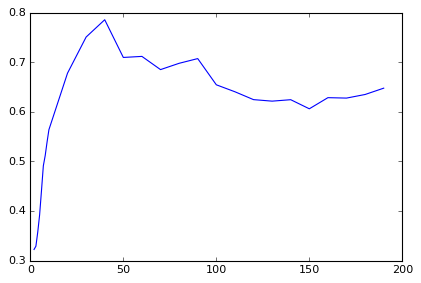

In [29]:
plt.plot(k_score)

In [32]:
gc.collect()

61

In [ ]:
patient_df_2 = diabetic_data_first_encounter[patient_features]
def get_age(age_group):
    return np.mean([int(x) for x in age_group.replace('[','').replace(')','').split('-')])
patient_df_2['age'] = patient_df_2['age'].apply(get_age)

In [ ]:
# Try using PCA for dimension reduction for the numerical columns.
cols_to_pca = ['number_outpatient','number_emergency','number_inpatient']
reduced_data = PCA(n_components=1).fit_transform(patient_df_2[cols_to_pca])
patient_df_2['hospitalizations'] = reduced_data
for col in cols_to_pca:
    del patient_df_2[col]
    
cols_to_normalize = ['age','hospitalizations']
for col in cols_to_normalize:
    patient_df_2[col] = (patient_df_2[col] - patient_df_2[col].min()) / (patient_df_2[col].max() - patient_df_2[col].min())

cols_to_one_hot = [u'race', u'gender',u'admission_type_id',u'admission_source_id',u'payer_code']
dummy_df = pd.get_dummies(patient_df_2[cols_to_one_hot])
patient_df_2 = pd.concat([patient_df_2,dummy_df],axis=1)
for col in cols_to_one_hot:
    del patient_df_2[col]
gc.collect()


In [ ]:
#Find best k
res = []
for k in range(2,10):
    kmeans = KMeans(n_clusters=k,random_state=0,n_jobs=3).fit(patient_df_2)
    patient_df['cluster'] = kmeans.labels_
    del kmeans
    sample = patient_df.sample(10000)
    score = metrics.silhouette_score(sample.iloc[:,:-1],sample.iloc[:,-1])
    print k,score
    res.append(score)
    gc.collect()
    
for k in range(10,200,10):
    kmeans = KMeans(n_clusters=k,random_state=0,n_jobs=3).fit(patient_df_2)
    patient_df['cluster'] = kmeans.labels_
    del kmeans
    sample = patient_df.sample(10000)
    score = metrics.silhouette_score(sample.iloc[:,:-1],sample.iloc[:,-1])
    print k,score
    res.append(score)
    gc.collect()

In [41]:
l = []
for k in range(2,10):
    l.append(k)
for k in range(10,200,10):
    l.append(k)
k_score = pd.DataFrame(res,index=l)

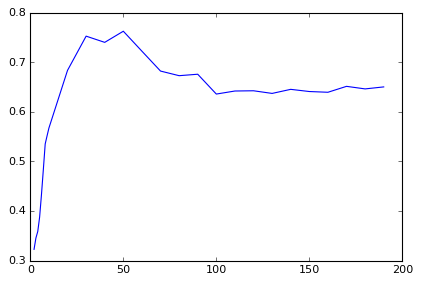

In [42]:
plt.plot(k_score)

In [53]:
best_k = 30
kmeans = KMeans(n_clusters=best_k,random_state=0,n_jobs=3).fit(patient_df)
diabetic_data_first_encounter['cluster'] = kmeans.labels_

### 2.Similarity / Distance matrix

Attenpt to cluster data using similarity between samples.

In [68]:
patient_df = diabetic_data_first_encounter[patient_features]

In [59]:
race_dict = dict(zip(patient_df['race'].unique(),range(patient_df['race'].nunique())))
gender_dict = dict(zip(patient_df['gender'].unique(),range(patient_df['gender'].nunique())))
payer_code_dict = dict(zip(patient_df['payer_code'].unique(),range(patient_df['payer_code'].nunique())))

In [ ]:
patient_df['race'] = patient_df['race'].apply(lambda x :race_dict[x])
patient_df['gender'] = patient_df['gender'].apply(lambda x :gender_dict[x])
patient_df['payer_code'] = patient_df['payer_code'].apply(lambda x :payer_code_dict[x])

In [36]:
# normalize numeric columns , so the distance will be on the same scale.
cols_to_normalize = ['age','number_outpatient','number_emergency','number_inpatient']
for col in cols_to_normalize:
    patient_df[col] = (patient_df[col] - patient_df[col].min()) / (patient_df[col].max() - patient_df[col].min())

/home/lizard/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [46]:
nominal_indices = [0,1,3,4,5]
numeric_indices = [2,6,7,8]

In [173]:
# For nominal features , the similarit will be in an inverse ratio to the general probability
nominal_coefficient = []
for i in range(6):
    nominal_coefficient.append({})
for idx in nominal_indices:
    nominal_coefficient[idx] = dict(1 / patient_df.iloc[:,idx].value_counts(normalize=True))

In [195]:
# Function that returns similarity between 2 samples.
def get_similarity(x_1,x_2):
    sim = np.zeros(9)
    sim[nominal_indices] =  [int(x) for x in x_1[nominal_indices] == x_2[nominal_indices]]
    for idx in nominal_indices:
        sim[idx] = sim[idx] * nominal_coefficient[idx][int(x_1[idx])]
    sim[numeric_indices] = 1 - np.abs(x_1[numeric_indices] - x_2[numeric_indices])   
    return np.mean(sim)

In [202]:
# Due to resources limitation only cluster 10,000 samples.
sample_df = patient_df.sample(10000)
vals = sample_df.values
sim = distance.cdist(vals,vals,get_similarity)

In [ ]:
adj_mat = np.array(sim)
sc = SpectralClustering(30, affinity='precomputed', n_init=100)
sc.fit(adj_mat)

In [111]:
sample_df['cluster'] = sc.labels_
sample_df['Unnamed: 0'] = sample_df.index
spectral_clutering = diabetic_data_first_encounter.merge(sample_df[['Unnamed: 0','cluster']],on='Unnamed: 0')